In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install numpy pandas matplotlib seaborn scikit-learn opencv-python pillow tensorflow tf-explain tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00


In [3]:
# 📊 Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🖼️ Image Processing
import cv2
from PIL import Image
import os
from tqdm import tqdm

# 🧠 Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# 🧪 Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 🔥 Grad-CAM (Optional — for visualization)
from tf_explain.core.grad_cam import GradCAM

# 🌌 Set up plotting styles (optional aesthetics)
plt.style.use('ggplot')
sns.set()

print("Imported All")

Imported All


In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Your original dataset path with all images in class folders
ORIGINAL_DATASET = "/content/drive/MyDrive/Diabetic_Retinopathy_Custom_Dataset"

# Destination base folder where you want to create train/val/test folders
DESTINATION_FOLDER = "/content/drive/MyDrive/DR_Splitted_Dataset"

# Classes (folder names)
CLASS_NAMES = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

# Split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

assert TRAIN_RATIO + VAL_RATIO + TEST_RATIO == 1.0, "Ratios must sum to 1"

# Create directory structure
for split in ['train', 'val', 'test']:
    for cls in CLASS_NAMES:
        os.makedirs(os.path.join(DESTINATION_FOLDER, split, cls), exist_ok=True)

# Function to copy files according to splits
for cls in CLASS_NAMES:
    print(f"\nProcessing class '{cls}'")
    src_folder = os.path.join(ORIGINAL_DATASET, cls)
    files = os.listdir(src_folder)

    # Shuffle files for randomness
    np.random.shuffle(files)

    # Calculate split indices
    total_files = len(files)
    train_end = int(total_files * TRAIN_RATIO)
    val_end = train_end + int(total_files * VAL_RATIO)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # Copy files to train folder
    for f in tqdm(train_files, desc=f"Copying train/{cls}"):
        shutil.copy2(os.path.join(src_folder, f), os.path.join(DESTINATION_FOLDER, 'train', cls, f))

    # Copy files to val folder
    for f in tqdm(val_files, desc=f"Copying val/{cls}"):
        shutil.copy2(os.path.join(src_folder, f), os.path.join(DESTINATION_FOLDER, 'val', cls, f))

    # Copy files to test folder
    for f in tqdm(test_files, desc=f"Copying test/{cls}"):
        shutil.copy2(os.path.join(src_folder, f), os.path.join(DESTINATION_FOLDER, 'test', cls, f))

print("\n✅ Dataset splitted successfully!")


Processing class 'No_DR'


Copying test/No_DR: 100%|██████████| 272/272 [00:02<00:00, 92.15it/s]



Processing class 'Mild'


Copying test/Mild: 100%|██████████| 38/38 [00:00<00:00, 76.83it/s]



Processing class 'Moderate'


Copying test/Moderate: 100%|██████████| 151/151 [00:01<00:00, 77.99it/s]



Processing class 'Severe'


Copying test/Severe: 100%|██████████| 30/30 [00:00<00:00, 86.50it/s]



Processing class 'Proliferate_DR'


Copying test/Proliferate_DR: 100%|██████████| 45/45 [00:00<00:00, 79.91it/s]


✅ Dataset splitted successfully!


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Paths
TRAIN_DIR = "/content/drive/MyDrive/DR_Splitted_Dataset/train"
VAL_DIR = "/content/drive/MyDrive/DR_Splitted_Dataset/val"
TEST_DIR = "/content/drive/MyDrive/DR_Splitted_Dataset/test"

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 5
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 10

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)  # Important for mixed precision

model = Model(inputs=base_model.input, outputs=outputs)

# Compile Phase 1
model.compile(
    optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-4)),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
]

# Train head only (Phase 1)
history1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n🔥Test Accuracy: {test_acc * 100:.2f}%")

Found 2476 images belonging to 5 classes.
Found 528 images belonging to 5 classes.
Found 536 images belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2247s 14s/step - accuracy: 0.2200 - loss: 1.7542 - val_accuracy: 0.4678 - val_loss: 1.5132
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - accuracy: 0.2565 - loss: 1.6081 - val_accuracy: 0.4375 - val_loss: 1.4903
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 83s 295ms/step - accuracy: 0.2937 - loss: 1.6217 - val_accuracy: 0.6723 - val_loss: 1.3628
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 45s 293ms/step - accuracy: 0.4087 - loss: 1.5716 - val_accuracy: 0.6837 - val_loss: 1.2318
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.4265 - loss: 1.4887 - val_accuracy: 0.5095 - val_loss: 1.1193
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 45s 289ms/step - accuracy: 0.4515 - loss: 1.5601 - val_accuracy: 0.4867 - val_loss: 1.0504
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.4926 - loss: 1.4497 - val_accuracy: 0.4943 - val_loss: 1.0397
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - accuracy: 0.4997 - loss: 1

In [6]:
# Unfreeze last 50 layers (Phase 2)
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile for fine-tuning
model.compile(
    optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-5)),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
history2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n🔥 Final Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 114s 446ms/step - accuracy: 0.5057 - loss: 1.6661 - val_accuracy: 0.5265 - val_loss: 1.1947
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 99s 298ms/step - accuracy: 0.5038 - loss: 1.4260 - val_accuracy: 0.6534 - val_loss: 1.0092
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 85s 315ms/step - accuracy: 0.5010 - loss: 1.4326 - val_accuracy: 0.7178 - val_loss: 0.9189
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 47s 301ms/step - accuracy: 0.5283 - loss: 1.4676 - val_accuracy: 0.5833 - val_loss: 0.9234
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.5350 - loss: 1.4028 - val_accuracy: 0.6174 - val_loss: 0.9251
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 46s 299ms/step - accuracy: 0.5680 - loss: 1.3070 - val_accuracy: 0.5322 - val_loss: 1.0865
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 351ms/step - accuracy: 0.5559 - loss: 1.3089 - val_accuracy: 0.6780 - val_loss: 0.8605
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 47s 301ms/step - accuracy: 0.5581 - loss: 

In [10]:
# Option A: Save the entire model (architecture + weights + optimizer state)
model.save('dr_resnet50_finetuned.keras')

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step
              precision    recall  f1-score   support

           0       0.34      0.58      0.43        38
           1       0.66      0.46      0.54       151
           2       0.87      0.94      0.91       272
           3       0.18      0.20      0.19        45
           4       0.21      0.17      0.19        30

    accuracy                           0.67       536
   macro avg       0.45      0.47      0.45       536
weighted avg       0.68      0.67      0.67       536



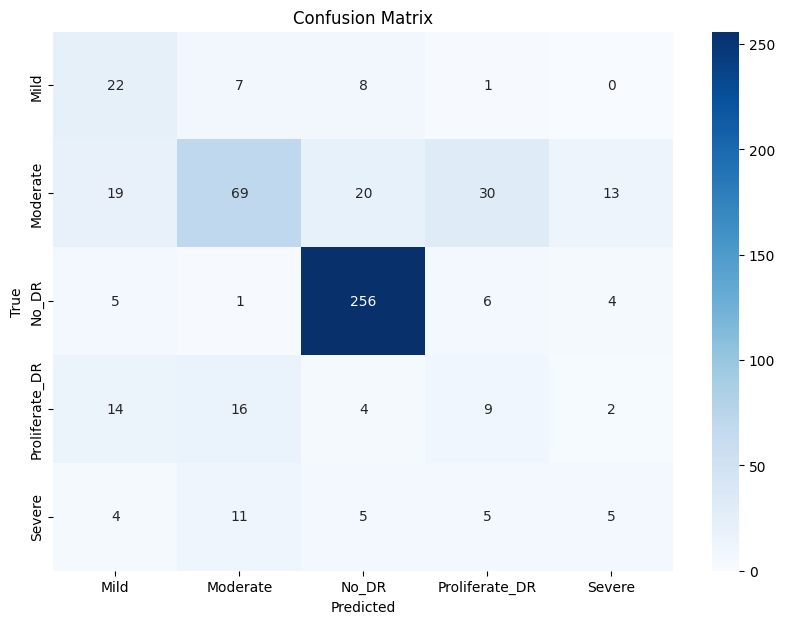

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# 1. Load your saved model
model = tf.keras.models.load_model('dr_resnet50_finetuned.keras', compile=False)

# 2. Define your classes
CLASS_NAMES = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

# 3. Single-image prediction
def predict_dr(img_path, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    x   = image.img_to_array(img)
    x   = np.expand_dims(x, axis=0)
    x   = preprocess_input(x)
    preds = model.predict(x)[0]
    idx   = np.argmax(preds)
    return CLASS_NAMES[idx], preds[idx]

# 4. Example usage
sample_image = '/content/drive/MyDrive/final_dataset/test/Moderate/00e4ddff966a.png'
label, confidence = predict_dr(sample_image)
print(f"Predicted: {label} ({confidence*100:.1f}% confidence)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: Moderate (100.0% confidence)
